# GALAXY GAN

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Input, Reshape, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist

from keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip /content/drive/MyDrive/GALAXY/galaxy.zip

Archive:  /content/drive/MyDrive/GALAXY/galaxy.zip
   creating: galaxy/
  inflating: galaxy/gen_124_5185.jpg  
  inflating: galaxy/gen_99_6389.jpg  
  inflating: galaxy/gen_104_5950.jpg  
  inflating: galaxy/gen_144_2638.jpg  
  inflating: galaxy/gen_315_9186.jpg  
  inflating: galaxy/gen_997_9278.jpg  
  inflating: galaxy/gen_690_8277.jpg  
  inflating: galaxy/gen_20_6390.jpg  
  inflating: galaxy/gen_662_84.jpg   
  inflating: galaxy/gen_1249_9970.jpg  
  inflating: galaxy/gen_98_5462.jpg  
  inflating: galaxy/gen_105_7911.jpg  
  inflating: galaxy/gen_322_6869.jpg  
  inflating: galaxy/gen_266_3422.jpg  
  inflating: galaxy/gen_276_9386.jpg  
  inflating: galaxy/gen_164_6346.jpg  
  inflating: galaxy/gen_52_2920.jpg  
  inflating: galaxy/gen_286_5352.jpg  
  inflating: galaxy/gen_622_2856.jpg  
  inflating: galaxy/potw2037a.jpg    
  inflating: galaxy/gen_85_3558.jpg  
  inflating: galaxy/gen_587_4637.jpg  
  inflating: galaxy/gen_112_1763.jpg  
  inflating: galaxy/gen_134_9527.jpg 

In [ ]:
def load_images_from_folder(folder, to_gray = False):
    """
    Function load images from file.
        
        Arguments:
        folder - (str) path to folder
        to_gray - (bool) whether to load in grayscale
        
        Returns:
        images - numpy array with all images from path
    """
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if to_gray == True:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img is not None:
            images.append(img)
    return images

In [ ]:
# loading images to grayscale
images = load_images_from_folder(folder='galaxy', to_gray = True)
images = np.array(images)

print('Number of images:', images.shape[0])
print('Images shape:', images.shape[1:3])

Number of images: 2880
Images shape: (192, 256)


In [ ]:
# Convert pixel values from [0, 255] to [-1, 1]

print('Pixel values before converting:')
print('MIN pixel value:',np.min(images[0]))
print('MAX pixel value:',np.max(images[0]))
print('\n')

images = (images/127.5) - 1

print('Pixel values after converting:')
print('MIN pixel value:',np.min(images[0]))
print('MAX pixel value:',np.max(images[0]))

Pixel values before converting:
MIN pixel value: 3
MAX pixel value: 244


Pixel values after converting:
MIN pixel value: -0.9764705882352941
MAX pixel value: 0.9137254901960785


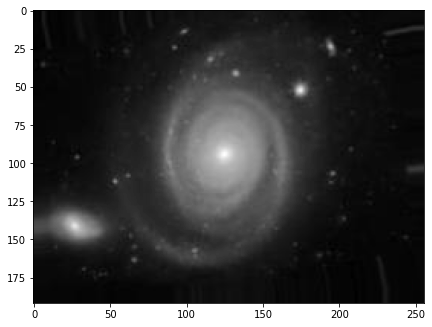

In [ ]:
# Plot example image
plt.figure(figsize = (7,7))
plt.imshow(images[np.random.randint(0,2880)], cmap='gray')
plt.show()

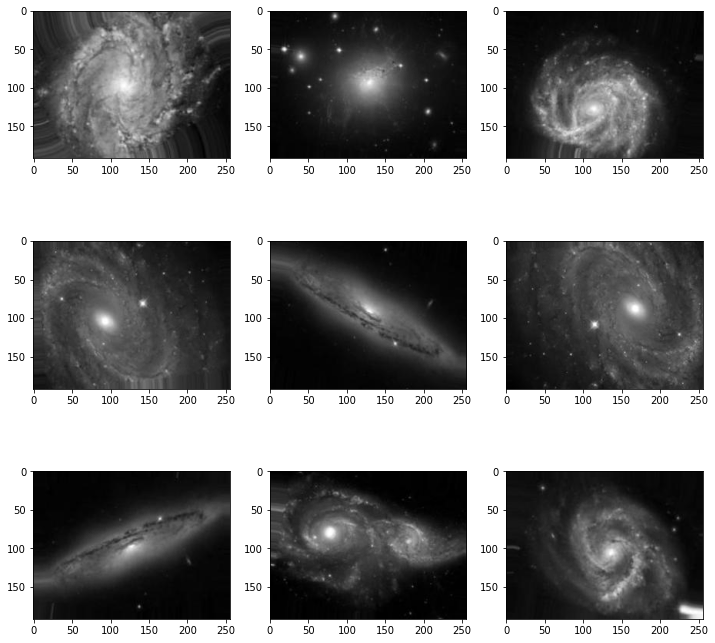

In [ ]:
# plot some images
plt.figure(figsize = (12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i], cmap='gray')
plt.show()

In [ ]:
# Reshape images to faltten vector
images = images.reshape(images.shape[0], 192*256)
print('Data shape:',images.shape)

Data shape: (2880, 49152)


In [ ]:
# GENERATOR

generator = Sequential([
    Input(shape=100),
    Flatten(),
    Dense(1024), LeakyReLU(),
    Dense(2048), LeakyReLU(),
    Dense(192*256), LeakyReLU(),
    Reshape((192, 256,1)),
    Conv2D(64, kernel_size=(5,5), padding='same', strides=(2, 2)), LeakyReLU(),
    MaxPooling2D(pool_size=(3,3)),
    Conv2D(32, kernel_size=(5,5), padding='same', strides=(2, 2)), LeakyReLU(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(192*256, activation="tanh")
])

In [ ]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 1024)              103424    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dense_17 (Dense)            (None, 2048)              2099200   
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 49152)             100712448 
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 49152)            

In [ ]:
# DISCRIMINATOR

discriminator = Sequential([
    Input(shape=192*256),
    Reshape((192, 256,1)),
    Conv2D(32, kernel_size=(3,3), padding='same', strides=(2, 2)), LeakyReLU(0.2),
    MaxPooling2D(pool_size=(3,3)),
    Conv2D(64, kernel_size=(4,4), padding='same', strides=(1,1)), LeakyReLU(0.2),
    MaxPooling2D(pool_size=(3,3)),
    Flatten(),
    Dense(2048), LeakyReLU(0.2), 
    Dense(1024), LeakyReLU(0.2),
    Dense(512), LeakyReLU(0.2), 
    Dense(1, activation="sigmoid") # prawdziwy-1, falszywy-0
])

In [ ]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 192, 256, 1)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 96, 128, 32)       320       
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 96, 128, 32)       0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 32, 42, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 42, 64)        32832     
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 32, 42, 64)        0         
                                                      

In [ ]:
def random_input(instance_count):
    """
    Function returns random vector which will be generator input.
        
        Arguments:
        instance_count - (int) number of generated vectors
        
        Returns:
        array - numpy array of shape (instance_count, 1000) with random values form normal distribution
    """
    return np.random.normal(0,1,[instance_count, 100])

In [ ]:
# Define GAN network
gan = Sequential([generator, discriminator])

# compile dicriminator - at the begining moves all the layer's weights to non-trainable
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
discriminator.trainable=False

# compile GAN
gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 0


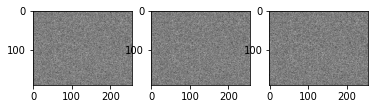

Epoch 1


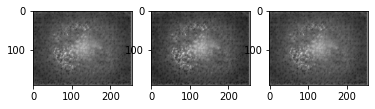

Epoch 2


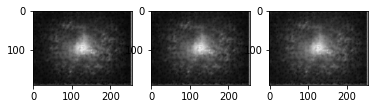

Epoch 3


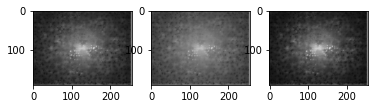

Epoch 4


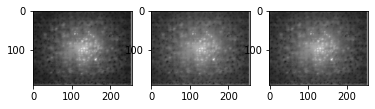

Epoch 5


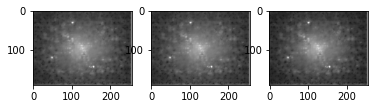

Epoch 6


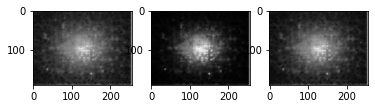

Epoch 7


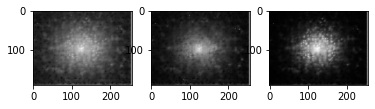

Epoch 8


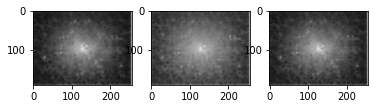

Epoch 9


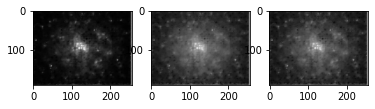

Epoch 10


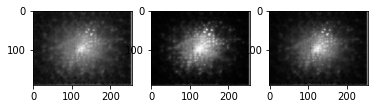

Epoch 11


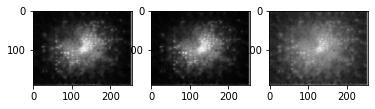

Epoch 12


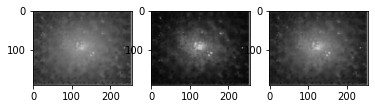

Epoch 13


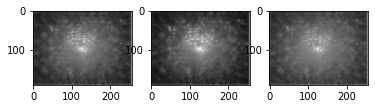

Epoch 14


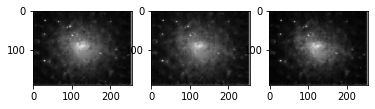

Epoch 15


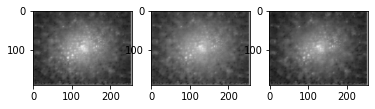

Epoch 16


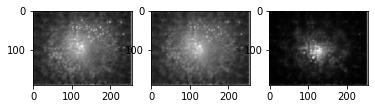

Epoch 17


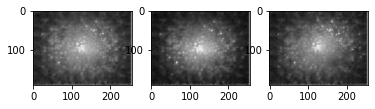

Epoch 18


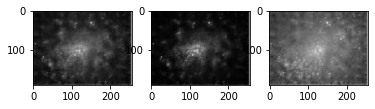

Epoch 19


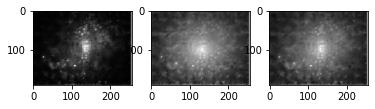

Epoch 20


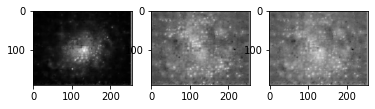

Epoch 21


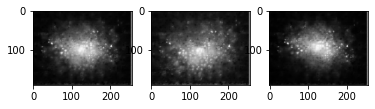

Epoch 22


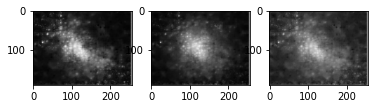

Epoch 23


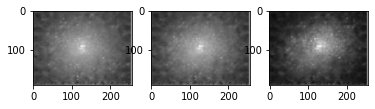

Epoch 24


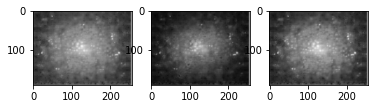

Epoch 25


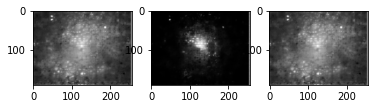

Epoch 26


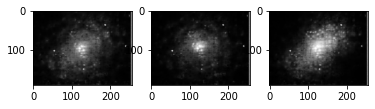

Epoch 27


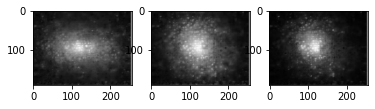

Epoch 28


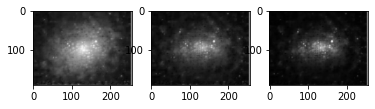

Epoch 29


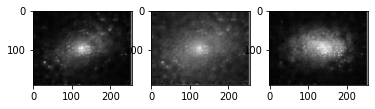

Epoch 30


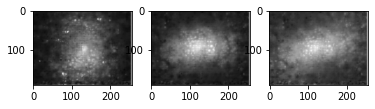

Epoch 31


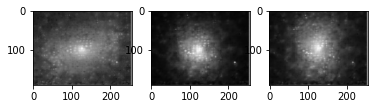

Epoch 32


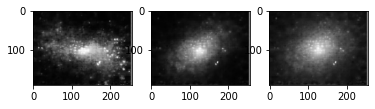

Epoch 33


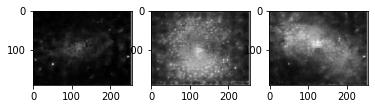

Epoch 34


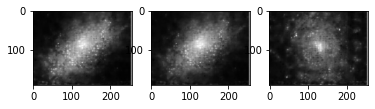

Epoch 35


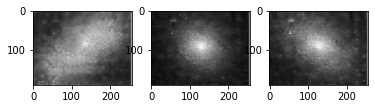

Epoch 36


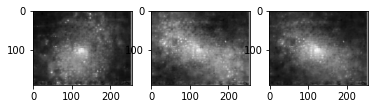

Epoch 37


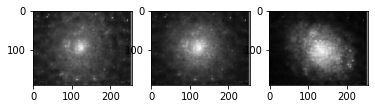

Epoch 38


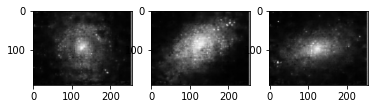

Epoch 39


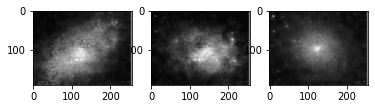

Epoch 40


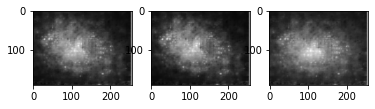

Epoch 41


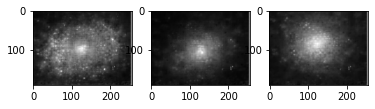

Epoch 42


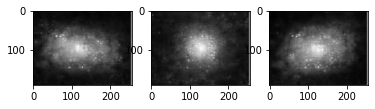

Epoch 43


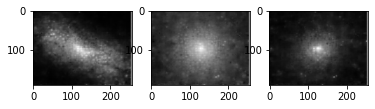

Epoch 44


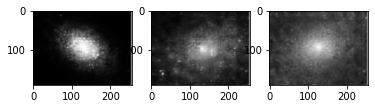

Epoch 45


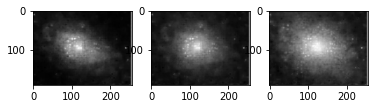

Epoch 46


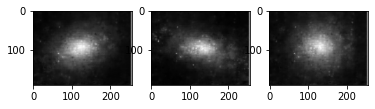

Epoch 47


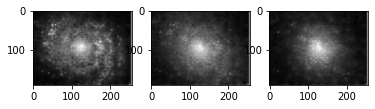

Epoch 48


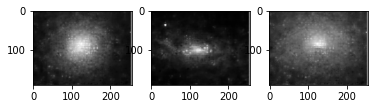

Epoch 49


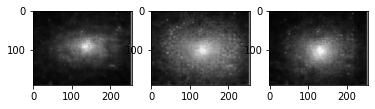

In [ ]:
n_epoch = 50
batch_size = 32
batch_count = int(images.shape[0] / batch_size) # approx number of batches in one epoch


for epoch in range(n_epoch):
    # Generate 3 random plots generated by our GENERATOR
    print("Epoch {}".format(epoch))
    images_to_plot = generator.predict(random_input(3))
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.imshow(images_to_plot[i].reshape(192,256), cmap='gray')
    plt.show()

    # for each batch in one epoch
    for batch in range(batch_count):
        # Generate {batch_size} number of fake images and labels (0 - fake)
        X_fake = generator.predict(random_input(batch_size)) # images from generator
        y_fake = np.zeros(batch_size) # labels
    
        # Take {batch_size} true images and generate true labels (1 - real)
        rand_ind = np.random.randint(0, images.shape[0], batch_size)
        X_real = images[rand_ind] # take random sample images from training dataset
        y_real = np.ones(batch_size)
    
        # concatenate real and fake images and labels
        X = np.concatenate([X_real, X_fake])   # images
        y = np.concatenate([y_real, y_fake])  # labels
    
        # train dicriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y)
    
        # disable dicriminator training, then train generator on the fake images witch true labels
        discriminator.trainable = False
        gan.train_on_batch(random_input(batch_size), np.ones(batch_size))

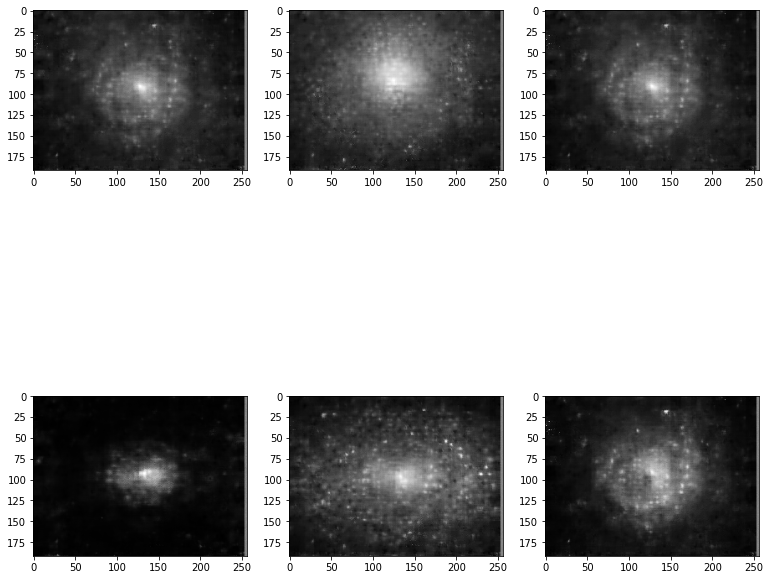

In [ ]:
# Plot GAN results

images_to_plot = generator.predict(random_input(6))
plt.figure(figsize = (13,13))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images_to_plot[i].reshape(192,256), cmap='gray')
plt.show()